In [113]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# 1. Importing The Librairies

In [114]:
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import Sequential
import seaborn as sns

# 2. Loading The Data

In [115]:
# Load the data
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
# Convert to numpy amd read the first column

y = train.to_numpy()[:,0]

# Convert to numpy and read all the column from 1 to all

X = train.to_numpy()[:,1:]

X_test = test.to_numpy()[:,:]

In [117]:
X.shape, y.shape

((42000, 784), (42000,))

In [118]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [119]:
y

array([1, 0, 1, ..., 7, 6, 9])

# 3. Display some digits

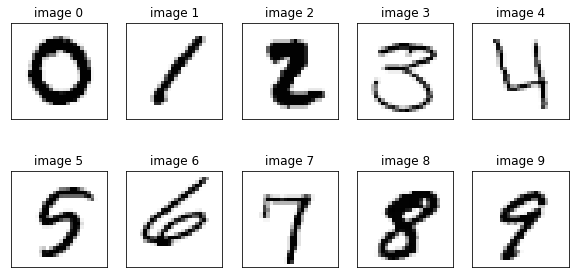

In [120]:
# Visualize an image for each digit
fig, axs = plt.subplots(2, 5, figsize=(10, 5))

for i in range(10):
    # get a boolean mask for all images with label
    mask = y == i
    #get the first image with label i
    image = X[mask][0].reshape(28, 28)
    # show the image
    axs[i//5, i%5].set_title(f'image {i}')
    axs[i//5, i%5].imshow(image, cmap='Greys')
    axs[i//5, i%5].set_xticks([])
    axs[i//5, i%5].set_yticks([])

# 4. Prepare the data for the model

In [121]:
# Split the data into training (80%) and validation (20%) dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 20, random_state = 126536, stratify = y)

In [122]:
print("X train Shape: ", X_train.shape)
print("y train Shape: ", y_train.shape)
print("X test Shape: ", X_valid.shape)
print("y test Shape: ", y_valid.shape)

X train Shape:  (41980, 784)
y train Shape:  (41980,)
X test Shape:  (20, 784)
y test Shape:  (20,)


In [123]:
# We create tensorflow dataset objects to feed data into keras models.
# this allows to reduce the images pixel values in the range of -1,1

preprocessing_data = lambda x : (x-127.5)/175 
train = tf.data.Dataset.from_tensor_slices(((preprocessing_data(X_train)), (y_train)))
valid = tf.data.Dataset.from_tensor_slices(((preprocessing_data(X_valid)), (y_valid)))

# # we give only the inputs for test dataset since we don't know the targets
test = tf.data.Dataset.from_tensor_slices((preprocessing_data(X_test)))

In [124]:
# We shuffle,batch and cache the training dataset.
# We batch and cache the validation dataset.
# We add prefetch to both to allow tensorflow to prepare data while training on batches in the GPU (useful with bigger images, here it is just a showcase of this feature)

train_cached = train.shuffle(X_train.shape[0]).batch(256).cache().prefetch(tf.data.AUTOTUNE)
valid_cached = valid.batch(256).cache().prefetch(tf.data.AUTOTUNE)

In [125]:
#plot both accuracy and loss comparing train and validation performance

def plot_accuracy_loss(history):
    plot = 0
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    ax = plt.gca()
    ax.set_ylim([0.85, 1])
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax = plt.gca()
    ax.set_ylim([0, 0.5])
    plt.show()
    plt.savefig('./Loss_Acc_'+str(plot)+'.png')
    plot = plot + 1

    
def get_mistakes(y_true,y_pred):
    size=len(y_true)
    mask=y_true!=y_pred
    y_true=y_true[mask]
    y_pred=y_pred[mask]
    matrix=np.zeros((10,10))
    for i in range(len(y_true)):
        matrix[y_true[i],y_pred[i]]+=1
    return matrix


def try_model(model,train_cached,valid_cached,train,valid,epochs=50):
    print(f"This model has {model.count_params()} parameters")
    
    history=model.fit(train_cached,validation_data=valid_cached,verbose=0,epochs=epochs)
    #plot train and validation performance
    plot_accuracy_loss(history)
    #get target from train and valid dataset
    y_train_pred=np.argmax(model.predict(train.map(lambda x,y:x).batch(256)),axis=-1)
    y_valid_pred=np.argmax(model.predict(valid.map(lambda x,y:x).batch(256)),axis=-1)
    
    #plot mistakes made by the model using heatmaps
    ax = plt.axes()
    s=sns.heatmap(get_mistakes(y_train,y_train_pred), linewidths=.5,vmax=60,ax=ax)
    ax.set_title('training mistakes')
    s.set(xlabel='predicted digit', ylabel='true digit')
    plt.show()
    ax = plt.axes()
    s=sns.heatmap(get_mistakes(y_valid,y_valid_pred), linewidths=.5,vmax=25,ax=ax)
    s.set(xlabel='predicted digit', ylabel='true digit')
    ax.set_title('validation mistakes')
    plt.show()

# 5. Building The Model

In [126]:
model = tf.keras.Sequential(
    [
        layers.Input((28, 28, 1), name="Inputs"),
        layers.Lambda(lambda x: (x+1)/2,name="Lambda"),                                     #rotation and contrast want the image in 0,1 range not -1,1
        layers.Conv2D(32, 3, activation = 'relu', name="Conv_Layer"),
        layers.SpatialDropout2D(0.05, name="Dropout_1"),
        layers.MaxPooling2D(2, name="Pooling_layer1"),
        layers.Conv2D(64, 3, activation = 'relu', name="Conv_Layer2"),
        layers.SpatialDropout2D(0.05, name="Dropout_2"),
        layers.MaxPooling2D(2, name="Pooling_layer2"),
        layers.GlobalAveragePooling2D(name="avgPooling"),
        layers.Dense(64, activation = "relu", name="Dense_layer"),
        layers.Dense(10, activation = "softmax", name="outputs"),
    ]
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_Layer (Conv2D)          (None, 26, 26, 32)        320       
_________________________________________________________________
Dropout_1 (SpatialDropout2D) (None, 26, 26, 32)        0         
_________________________________________________________________
Pooling_layer1 (MaxPooling2D (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_Layer2 (Conv2D)         (None, 11, 11, 64)        18496     
_________________________________________________________________
Dropout_2 (SpatialDropout2D) (None, 11, 11, 64)        0         
_________________________________________________________________
Pooling_layer2 (MaxPooling2D (None, 5, 5, 64)         

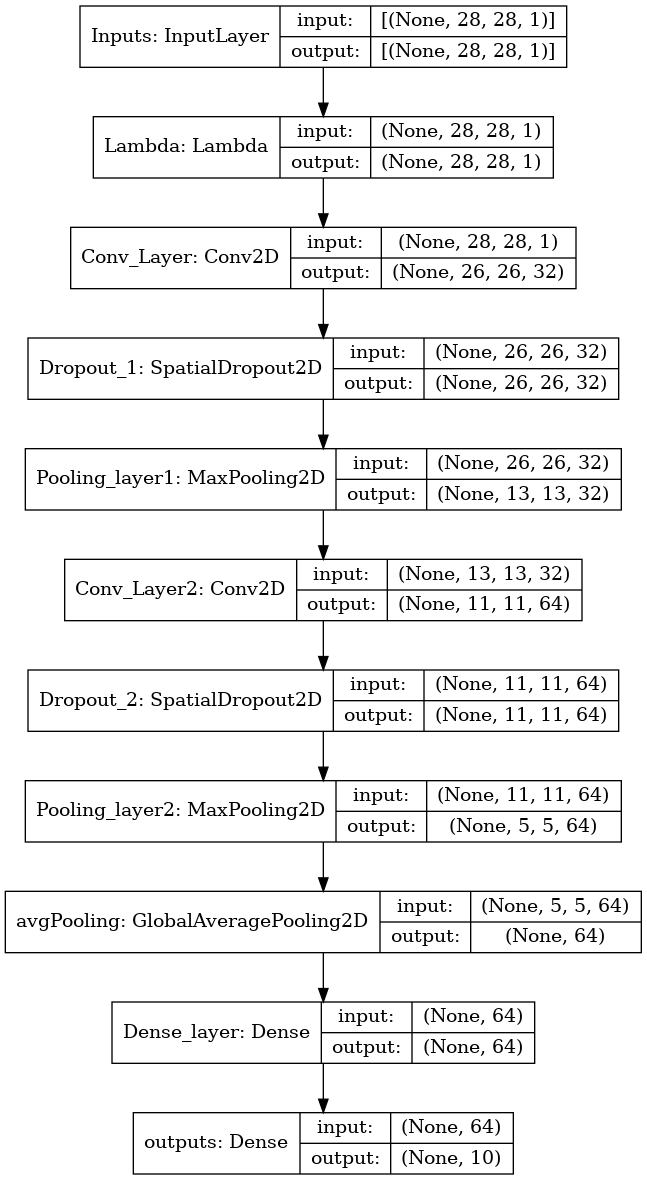

In [127]:
# #we compile the model and set to use the Adam Optimizer, Sparse Categorical Crossentropy as loss and accuracy as metric to monitor
model.compile(optimizer = "Adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_layer_names=True, expand_nested=True, show_shapes=True, rankdir="TB")

In [128]:
#for each row of the dataset reshape the input of the network to be a 28x28 image (1 means one channel since the images are greyscale)
#We keep the target y unchanged 
train_images=train.map(lambda x,y:(tf.reshape(x,(28,28,1)),y))
valid_images=valid.map(lambda x,y:(tf.reshape(x,(28,28,1)),y))

In [129]:
#We prepare the datasets by shuffling, batching, caching and prefetching
train_images_cached=train_images.shuffle(X_train.shape[0]).batch(256).cache().prefetch(tf.data.AUTOTUNE)
valid_images_cached=valid_images.batch(256).cache().prefetch(tf.data.AUTOTUNE)

This model has 23626 parameters


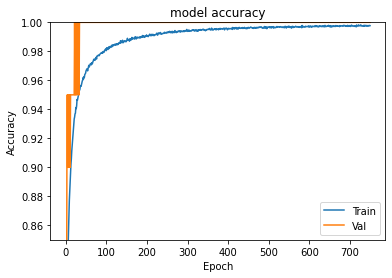

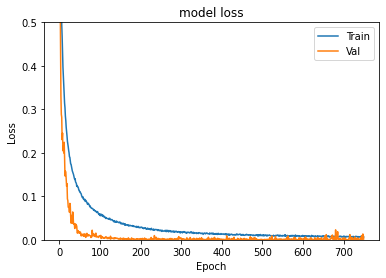

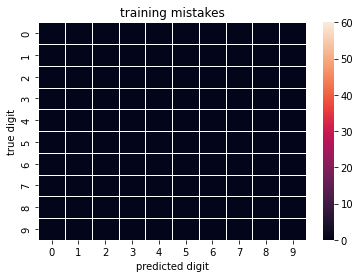

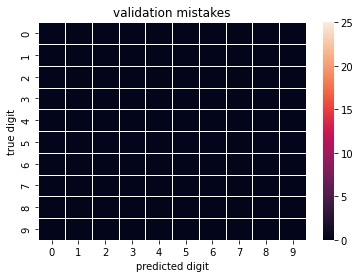

In [130]:
try_model(model, train_images_cached, valid_images_cached, train_images, valid_images, epochs = 750)

# 6. Making Predictions

In [131]:
# We reshape the test dataset to have 28x28 images
test_images=test.map(lambda x:(tf.reshape(x,(28,28,1))))
# We predict the digit of each test image
y_test=model.predict(test_images.batch(1024))
#we get the most likely class for each image
#y_test is a ndarray of size N images x 10 (10= N digits)
#By telling axis=-1(last axis) we are telling to find the most likely digit (last axis) for each images
preds=np.argmax(y_test,axis=-1)

In [132]:
#Read sample submission, place predictions into the Label column and save the submission csv
sub_df=pd.read_csv("../input/digit-recognizer/sample_submission.csv")
sub_df["Label"]=preds
sub_df.to_csv("submission.csv",index=None)

In [133]:
sub_df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,5
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
